In [1]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.functions import lit
from pyspark.sql.functions import col, isnan, count, when, isnull, size, split
from pyspark.sql.types import StructType, StructField, IntegerType, StringType, LongType, FloatType, DateType
from pyspark.sql.functions import col, regexp_replace
from pyspark.ml.linalg import Vectors
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, VectorAssembler


In [2]:
spark = SparkSession.builder.appName('big_data_final_project').getOrCreate()

In [3]:
# Put in your bucket and folder path without the csv file
#BUCKET = 'gs://bucket-ji/notebooks/jupyter/data/' 

data_with_review = spark.read.csv('gs://bucket-ji/notebooks/jupyter/real-final-data.csv',inferSchema=True,header=True)
data_with_zero_review = spark.read.csv('gs://bucket-ji/notebooks/jupyter/target_column_with_zero_review.csv',inferSchema=True,header=True)

In [4]:
# Double check the data was read in properly
data_with_review.head()

Row(host_total_listings_count=3.0, accommodates=8, num_bath=3.0, bedrooms=4.0, beds=6.0, price=500.0, amenities_count=14, essential_amenities=3, host_is_superhost='t', city='Broward County', room_type='Entire home/apt', full_time_host='f', host_verifications_clean='ep', target='Great')

In [5]:
# Double check the data was read in properly
data_with_zero_review.head()

Row(id=827736378366911479, host_id=475630606, host_since='2022-08-18', host_location='Unknown', host_is_superhost='f', host_listings_count=1.0, host_total_listings_count=3.0, host_has_profile_pic='t', host_identity_verified='t', neighborhood='Fort Lauderdale', latitude=26.09393643124416, longitude=-80.13759087771177, room_type='Entire home/apt', accommodates=2, num_bath=1.0, bedrooms=1.0, beds=1.0, price=222.0, number_of_reviews=0, review_scores_value=None, calculated_host_listings_count=1, city='Broward County', amenities_count=10, neighborhood_city='Fort Lauderdale Broward County', full_time_host='f', host_verifications_clean='p', essential_amenities=3)

In [6]:
# Drop columns that can't be used in the feature pipeline as not applicable to zero reviews
data_with_zero_review = data_with_zero_review.drop('review_scores_value')
data_with_zero_review = data_with_zero_review.drop('number_of_reviews')

In [7]:
# Double check the columns in data_with_review
data_with_review.columns

['host_total_listings_count',
 'accommodates',
 'num_bath',
 'bedrooms',
 'beds',
 'price',
 'amenities_count',
 'essential_amenities',
 'host_is_superhost',
 'city',
 'room_type',
 'full_time_host',
 'host_verifications_clean',
 'target']

### Create the Feature Pipeline

In [80]:
# List of string features to be indexed and the features that are already numeric
stringFeatures = ['host_is_superhost', 'city', 'room_type', 'full_time_host', 'host_verifications_clean']

numericFeatures = ['host_total_listings_count', 'accommodates', 
                   'num_bath','bedrooms', 'beds', 'price',
                   'amenities_count', 'essential_amenities']

# Create StringIndexer stages for the stringFeatures - call the numeric version as _indexed
indexers = [StringIndexer(inputCol=column, outputCol=column+"_indexed", stringOrderType="alphabetAsc").setHandleInvalid("skip")
            for column in stringFeatures]

# Create a StringIndexer for the target column and naming it as target_label after converting it to numeric
labelIndexer = StringIndexer(inputCol='target', outputCol='target_label').setHandleInvalid("skip")

# Create VectorAssembler stage for the features
assemblerInputs = [column+"_indexed" for column in stringFeatures] + numericFeatures
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")

# Create and run the pipeline with the target indexer added to pipeline
pipeline = Pipeline(stages=indexers + [assembler, labelIndexer])

# Fit the pipeline on the training data - which is all of data that has reviews
pipelineModel = pipeline.fit(data_with_review)

# Alternative code if we wanted to do the train/test split earlier as it depends if we want to do 80/20 or 70/30.
# trainingDataTransformed = pipelineModel.transform(trainingData)
# testDataTransformed = pipelineModel.transform(testData)

# Apply the pipeline on the data_with_review - trainingDataTransformed seen below will have to go through a train/test split
trainingDataTransformed = pipelineModel.transform(data_with_review)


# To apply the pipeline on the data_with_zero_review, which is missing the target, we need to do the following:
# Extracting the transformation stages from the fitted pipeline model
# Excldue the LabelIndexer from final pipeline stage as we are applying on the prediction dataset
transformationStages = pipelineModel.stages[:-1]

# Manually apply each transformation stage to the data_with_zero_review
transformedData = data_with_zero_review
for stage in transformationStages:
    transformedData = stage.transform(transformedData)

# We now have dataWithZeroReviewTransformed which doesn't have the target_label column to see what is our final model predictions
dataWithZeroReviewTransformed = transformedData

### Check if Feature Pipeline was done properly

In [9]:
trainingDataTransformed.printSchema()

root
 |-- host_total_listings_count: double (nullable = true)
 |-- accommodates: integer (nullable = true)
 |-- num_bath: double (nullable = true)
 |-- bedrooms: double (nullable = true)
 |-- beds: double (nullable = true)
 |-- price: double (nullable = true)
 |-- amenities_count: integer (nullable = true)
 |-- essential_amenities: integer (nullable = true)
 |-- host_is_superhost: string (nullable = true)
 |-- city: string (nullable = true)
 |-- room_type: string (nullable = true)
 |-- full_time_host: string (nullable = true)
 |-- host_verifications_clean: string (nullable = true)
 |-- target: string (nullable = true)
 |-- host_is_superhost_indexed: double (nullable = false)
 |-- city_indexed: double (nullable = false)
 |-- room_type_indexed: double (nullable = false)
 |-- full_time_host_indexed: double (nullable = false)
 |-- host_verifications_clean_indexed: double (nullable = false)
 |-- features: vector (nullable = true)
 |-- target_label: double (nullable = false)



In [10]:
dataWithZeroReviewTransformed.printSchema()

root
 |-- id: long (nullable = true)
 |-- host_id: integer (nullable = true)
 |-- host_since: string (nullable = true)
 |-- host_location: string (nullable = true)
 |-- host_is_superhost: string (nullable = true)
 |-- host_listings_count: double (nullable = true)
 |-- host_total_listings_count: double (nullable = true)
 |-- host_has_profile_pic: string (nullable = true)
 |-- host_identity_verified: string (nullable = true)
 |-- neighborhood: string (nullable = true)
 |-- latitude: double (nullable = true)
 |-- longitude: double (nullable = true)
 |-- room_type: string (nullable = true)
 |-- accommodates: integer (nullable = true)
 |-- num_bath: double (nullable = true)
 |-- bedrooms: double (nullable = true)
 |-- beds: double (nullable = true)
 |-- price: double (nullable = true)
 |-- calculated_host_listings_count: integer (nullable = true)
 |-- city: string (nullable = true)
 |-- amenities_count: integer (nullable = true)
 |-- neighborhood_city: string (nullable = true)
 |-- full_tim

In [11]:
trainingDataTransformed.show(n=1, truncate=False)

+-------------------------+------------+--------+--------+----+-----+---------------+-------------------+-----------------+--------------+---------------+--------------+------------------------+------+-------------------------+------------+-----------------+----------------------+--------------------------------+--------------------------------------------------------+------------+
|host_total_listings_count|accommodates|num_bath|bedrooms|beds|price|amenities_count|essential_amenities|host_is_superhost|city          |room_type      |full_time_host|host_verifications_clean|target|host_is_superhost_indexed|city_indexed|room_type_indexed|full_time_host_indexed|host_verifications_clean_indexed|features                                                |target_label|
+-------------------------+------------+--------+--------+----+-----+---------------+-------------------+-----------------+--------------+---------------+--------------+------------------------+------+-------------------------+---

In [ ]:
# Doing a quick check that the string indexer worked and converted the categorical values into an index
trainingDataTransformed.select('host_verifications_clean', 'host_verifications_clean_indexed').show(5)

trainingDataTransformed.select('room_type', 'room_type_indexed').show(10)

+------------------------+--------------------------------+
|host_verifications_clean|host_verifications_clean_indexed|
+------------------------+--------------------------------+
|                      ep|                             1.0|
|                      pw|                             8.0|
|                      ep|                             1.0|
|                      ep|                             1.0|
|                      ep|                             1.0|
+------------------------+--------------------------------+
only showing top 5 rows

+---------------+-----------------+
|      room_type|room_type_indexed|
+---------------+-----------------+
|Entire home/apt|              0.0|
|Entire home/apt|              0.0|
|Entire home/apt|              0.0|
|Entire home/apt|              0.0|
|Entire home/apt|              0.0|
|Entire home/apt|              0.0|
|   Private room|              2.0|
|   Private room|              2.0|
|   Private room|              2.0|
|  

In [18]:
# Checking that the target_label got created successfully
trainingDataTransformed.select('target', 'target_label').show(20)

+-------+------------+
| target|target_label|
+-------+------------+
|  Great|         0.0|
|Average|         1.0|
|Average|         1.0|
|Average|         1.0|
|  Great|         0.0|
|Average|         1.0|
|  Great|         0.0|
|Average|         1.0|
|Average|         1.0|
|Average|         1.0|
|  Great|         0.0|
|Average|         1.0|
|  Great|         0.0|
|  Great|         0.0|
|Average|         1.0|
|Average|         1.0|
|   Poor|         2.0|
|  Great|         0.0|
|  Great|         0.0|
|Average|         1.0|
+-------+------------+
only showing top 20 rows



In [19]:
# Examine all of the features with a particular target_label
trainingDataTransformed.select("features", "target_label").show(truncate=False)

+-----------------------------------------------------------+------------+
|features                                                   |target_label|
+-----------------------------------------------------------+------------+
|[1.0,1.0,0.0,0.0,1.0,3.0,8.0,3.0,4.0,6.0,500.0,14.0,3.0]   |0.0         |
|[0.0,1.0,0.0,0.0,8.0,12.0,6.0,2.0,2.0,4.0,186.0,22.0,4.0]  |1.0         |
|[0.0,1.0,0.0,0.0,1.0,20.0,7.0,2.0,2.0,5.0,297.0,17.0,3.0]  |1.0         |
|[0.0,1.0,0.0,0.0,1.0,5.0,4.0,1.0,1.0,2.0,162.0,69.0,5.0]   |1.0         |
|[0.0,1.0,0.0,0.0,1.0,17.0,2.0,1.0,1.0,1.0,92.0,17.0,4.0]   |0.0         |
|[1.0,1.0,0.0,0.0,1.0,1930.0,6.0,2.0,2.0,4.0,258.0,38.0,5.0]|1.0         |
|[1.0,1.0,2.0,0.0,4.0,1.0,4.0,1.0,1.0,2.0,100.0,72.0,4.0]   |0.0         |
|[0.0,1.0,2.0,0.0,8.0,19.0,4.0,1.0,1.0,2.0,189.0,60.0,5.0]  |1.0         |
|[1.0,1.0,2.0,0.0,1.0,2.0,3.0,1.0,1.0,1.0,63.0,67.0,5.0]    |1.0         |
|[0.0,1.0,2.0,0.0,1.0,13.0,2.0,1.0,1.0,1.0,127.0,51.0,5.0]  |1.0         |
|[0.0,1.0,2.0,0.0,1.0,112

In [20]:
# Examine if the dataWithZeroReviewTransformed features look like it was done correctly
dataWithZeroReviewTransformed.select('features').show(5)

+--------------------+
|            features|
+--------------------+
|[0.0,1.0,0.0,0.0,...|
|[0.0,1.0,2.0,0.0,...|
|[0.0,1.0,0.0,0.0,...|
|[0.0,1.0,2.0,0.0,...|
|[1.0,1.0,0.0,0.0,...|
+--------------------+
only showing top 5 rows



In [21]:
# See the count of each dataset to get an understanding on sizes:
num_rows = trainingDataTransformed.count()
num_columns = len(trainingDataTransformed.first())

print("For trainingDataTransformed:")
print(f"Number of Rows: {num_rows}, Number of Columns: {num_columns}")

num_rows = dataWithZeroReviewTransformed.count()
num_columns = len(dataWithZeroReviewTransformed.first())

print("For dataWithZeroReviewTransformed:")
print(f"Number of Rows: {num_rows}, Number of Columns: {num_columns}")

For trainingDataTransformed:
Number of Rows: 143995, Number of Columns: 21
For dataWithZeroReviewTransformed:
Number of Rows: 40989, Number of Columns: 31


# Multinomial logistic regression

In [22]:
from pyspark.ml.classification import LogisticRegression

In [23]:
# Do the train test split - we need to discuss what are we settng for the threshold
train_data,test_data = trainingDataTransformed.randomSplit([0.7,0.3], seed=42)

In [24]:
logr = LogisticRegression(labelCol='target_label',featuresCol='features')

In [25]:
# train the model
model = logr.fit(train_data)

In [26]:
# select example rows to display.
predictions = model.transform(test_data)
predictions.show(5)

+-------------------------+------------+--------+--------+----+-----+---------------+-------------------+-----------------+-------------+------------+--------------+------------------------+-------+-------------------------+------------+-----------------+----------------------+--------------------------------+--------------------+------------+--------------------+--------------------+----------+
|host_total_listings_count|accommodates|num_bath|bedrooms|beds|price|amenities_count|essential_amenities|host_is_superhost|         city|   room_type|full_time_host|host_verifications_clean| target|host_is_superhost_indexed|city_indexed|room_type_indexed|full_time_host_indexed|host_verifications_clean_indexed|            features|target_label|       rawPrediction|         probability|prediction|
+-------------------------+------------+--------+--------+----+-----+---------------+-------------------+-----------------+-------------+------------+--------------+------------------------+-------+----

In [27]:
# Selecting only the desired columns and displaying the DataFrame
predictions.select("target_label", "prediction", "probability").show()


+------------+----------+--------------------+
|target_label|prediction|         probability|
+------------+----------+--------------------+
|         0.0|       0.0|[0.45005866948329...|
|         0.0|       0.0|[0.43841708010307...|
|         1.0|       1.0|[0.44581065327795...|
|         2.0|       1.0|[0.41392304752494...|
|         1.0|       1.0|[0.41062700168587...|
|         0.0|       1.0|[0.41712633262714...|
|         2.0|       0.0|[0.47307320480449...|
|         2.0|       0.0|[0.48545639276322...|
|         1.0|       1.0|[0.43247550260513...|
|         0.0|       0.0|[0.46269394879173...|
|         0.0|       0.0|[0.46849070895071...|
|         0.0|       0.0|[0.46269285390658...|
|         2.0|       1.0|[0.43451092125412...|
|         0.0|       0.0|[0.47220455806718...|
|         2.0|       1.0|[0.42783124436212...|
|         0.0|       0.0|[0.45526162012307...|
|         0.0|       0.0|[0.44158780855756...|
|         0.0|       0.0|[0.49212118680380...|
|         0.0

In [28]:
# Counting the occurrences of each value in the "target_label" column
target_label_counts = predictions.groupBy("target_label").count()

# Counting the occurrences of each value in the "prediction" column
prediction_counts = predictions.groupBy("prediction").count()

# Displaying the counts
print("Target Label Counts:")
target_label_counts.show()

print("Prediction Counts:")
prediction_counts.show()


Target Label Counts:
+------------+-----+
|target_label|count|
+------------+-----+
|         0.0|21182|
|         1.0|18746|
|         2.0| 3044|
+------------+-----+

Prediction Counts:
+----------+-----+
|prediction|count|
+----------+-----+
|       0.0|23788|
|       1.0|18871|
|       2.0|  313|
+----------+-----+



In [29]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
# compute accuracy on the test set
evaluator = MulticlassClassificationEvaluator(labelCol="target_label", predictionCol="prediction",
                                              metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Test set accuracy = " + str(accuracy))

Test set accuracy = 0.5588057339663036


In [30]:
from pyspark.sql.functions import col

# Count predictions
confusion_matrix = predictions.groupBy('target_label').pivot('prediction', [0,1,2]).count().na.fill(0).orderBy('target_label')
confusion_matrix.show()

+------------+-----+----+---+
|target_label|    0|   1|  2|
+------------+-----+----+---+
|         0.0|13915|7123|144|
|         1.0| 8737|9969| 40|
|         2.0| 1136|1779|129|
+------------+-----+----+---+



# Hyper-Parameter Tuning

In [31]:
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [89]:
# create the trainer and set its parameters
logr = LogisticRegression(labelCol='target_label',featuresCol='features')

In [90]:
# Create the parameter grid
paramGrid = ParamGridBuilder() \
    .addGrid(logr.maxIter, [10, 20, 30]) \
    .addGrid(logr.regParam, [0.001, 0.01, 0.05, 0.1]) \
    .addGrid(logr.elasticNetParam, [0.0, 0.5, 1.0]) \
    .build()

In [91]:
# Define evaluator
evaluator = MulticlassClassificationEvaluator(labelCol="target_label", predictionCol="prediction", metricName="accuracy")

In [92]:
# Define cross-validator
crossval = CrossValidator(estimator=logr,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=5)  # 5-fold cross-validation

In [ ]:
# Run cross-validation, and choose the best set of parameters
cvModel_whole = crossval.fit(train_data)

# Get the best model from cross-validation
bestModel = cvModel_whole.bestModel

# Make predictions on the test data using the best model
predictions_tune = bestModel.transform(test_data)


In [ ]:
# Evaluate the performance of the best model
accuracy = evaluator.evaluate(predictions_tune)

print("Test Accuracy: ", accuracy)

Test Accuracy:  0.5600390952247976


In [38]:
# Extracting the parameter map
paramMap = bestModel.extractParamMap()

# Printing the best parameters
print("Best Parameters:")
for param, value in paramMap.items():
    print(param.name, ":", value)

Best Parameters:
aggregationDepth : 2
elasticNetParam : 0.0
family : auto
featuresCol : features
fitIntercept : True
labelCol : target_label
maxIter : 30
predictionCol : prediction
probabilityCol : probability
rawPredictionCol : rawPrediction
regParam : 0.01
standardization : True
threshold : 0.5
tol : 1e-06


In [39]:
# Count predictions
confusion_matrix = predictions_tune.groupBy('target_label').pivot('prediction', [0,1,2]).count().na.fill(0).orderBy('target_label')
confusion_matrix.show()

+------------+-----+----+---+
|target_label|    0|   1|  2|
+------------+-----+----+---+
|         0.0|14073|6977|132|
|         1.0| 8845|9874| 27|
|         2.0| 1159|1766|119|
+------------+-----+----+---+



# Feature Importance - Top 7 features

In [40]:
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml import Pipeline

# Defining string features and numeric features
stringFeatures = ['host_is_superhost', 'city', 'room_type', 'full_time_host', 'host_verifications_clean']
numericFeatures = ['host_total_listings_count', 'accommodates', 'num_bath', 'bedrooms', 'beds', 'price', 'amenities_count', 'essential_amenities']

# Create StringIndexer stages for the string features
indexers = [StringIndexer(inputCol=column, outputCol=column+"_indexed", stringOrderType="alphabetAsc").setHandleInvalid("skip")
            for column in stringFeatures]

# Create a StringIndexer for the target column and name it as target_label
labelIndexer = StringIndexer(inputCol='target', outputCol='target_label').setHandleInvalid("skip")

# Create VectorAssembler to combine feature columns into a single features column
assemblerInputs = [column+"_indexed" for column in stringFeatures] + numericFeatures
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")

# LogisticRegression Classifier - note the labelCol now matches the output of labelIndexer
logr = LogisticRegression(labelCol='target_label',featuresCol='features')

# Building the pipeline with all components including labelIndexer
pipeline = Pipeline(stages=indexers + [labelIndexer, assembler, logr])

# Fit the pipeline on the data with reviews
pipelineModel = pipeline.fit(data_with_review)

# Extract the LOGR model from the pipeline
logrModel = pipelineModel.stages[-1]  # Adjust the index if necessary based on the stages


In [41]:
from pyspark.ml.linalg import DenseMatrix
import numpy as np

# Extracting coefficients from the DenseMatrix
coefficients = logrModel.coefficientMatrix

# Convert the coefficient matrix to a NumPy array
coefficients_array = coefficients.toArray()

# Calculate the absolute values of the coefficients
abs_coefficients = np.abs(coefficients_array)

# Calculate the sum of absolute coefficients for each class
class_sum = abs_coefficients.sum(axis=1)

# Calculate the feature importance scores for each feature
feature_importance = abs_coefficients / class_sum[:, np.newaxis]

# Calculate the average importance scores across classes
avg_importance = feature_importance.mean(axis=0)

# Create a dictionary to map feature indices to feature names
feature_mapping = {i: col for i, col in enumerate(assemblerInputs)}

# Print or visualize the feature importance scores with feature names
for i, importance_score in enumerate(avg_importance):
    feature_name = feature_mapping[i]
    print(f"Feature '{feature_name}': Importance Score = {importance_score}")


Feature 'host_is_superhost_indexed': Importance Score = 0.4347679589850147
Feature 'city_indexed': Importance Score = 0.00796062493625395
Feature 'room_type_indexed': Importance Score = 0.022240755439864004
Feature 'full_time_host_indexed': Importance Score = 0.2747669675636599
Feature 'host_verifications_clean_indexed': Importance Score = 0.01296530818885751
Feature 'host_total_listings_count': Importance Score = 0.0002312244802717651
Feature 'accommodates': Importance Score = 0.020867456782659766
Feature 'num_bath': Importance Score = 0.044572145026032545
Feature 'bedrooms': Importance Score = 0.029110611699276433
Feature 'beds': Importance Score = 0.015933132091380062
Feature 'price': Importance Score = 5.895940426966078e-06
Feature 'amenities_count': Importance Score = 0.004467588200175361
Feature 'essential_amenities': Importance Score = 0.132110330666127


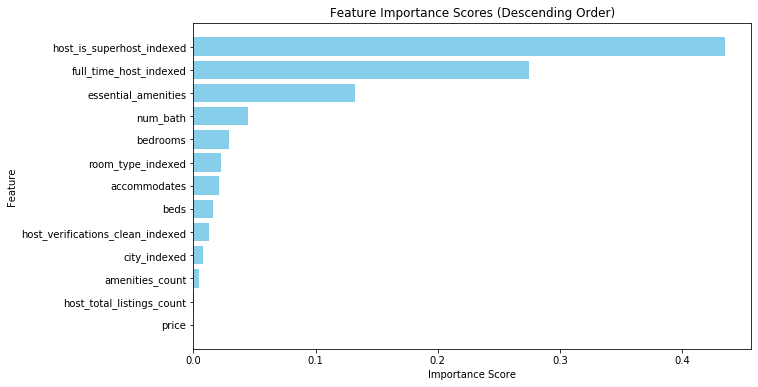

In [44]:
import matplotlib.pyplot as plt

# Get the feature names and importance scores
feature_names = [feature_mapping[i] for i in range(len(avg_importance))]
importance_scores = avg_importance

# Sort features based on importance scores in descending order
sorted_indices = sorted(range(len(importance_scores)), key=lambda i: importance_scores[i], reverse=False)
sorted_feature_names = [feature_names[i] for i in sorted_indices]
sorted_importance_scores = [importance_scores[i] for i in sorted_indices]

# Create a bar plot
plt.figure(figsize=(10, 6))
plt.barh(sorted_feature_names, sorted_importance_scores, color='skyblue')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.title('Feature Importance Scores (Descending Order)')
plt.show()


# Create Model with Top 10 Features

In [65]:
# Combine feature names and importance scores into tuples and sort them
feature_importance_tuples = list(zip(sorted_feature_names, sorted_importance_scores))
sorted_feature_importance = sorted(feature_importance_tuples, key=lambda x: x[1], reverse=True)
# Extract the top features and their importance scores
top_features = [feature for feature, _ in sorted_feature_importance[:10]]

In [66]:
top_features

['host_is_superhost_indexed',
 'full_time_host_indexed',
 'essential_amenities',
 'num_bath',
 'bedrooms',
 'room_type_indexed',
 'accommodates',
 'beds',
 'host_verifications_clean_indexed',
 'city_indexed']

In [67]:
# Remove the '_indexed' suffix from each feature name
top_features = [feature.replace('_indexed', '') for feature in top_features]
top_features

['host_is_superhost',
 'full_time_host',
 'essential_amenities',
 'num_bath',
 'bedrooms',
 'room_type',
 'accommodates',
 'beds',
 'host_verifications_clean',
 'city']

In [68]:
# Import OneHotEncoder
from pyspark.ml.feature import OneHotEncoder

# List of string features to be indexed and the features that are already numeric
stringFeatures = ['host_is_superhost', 'room_type', 'full_time_host', 'host_verifications_clean', 'city']

numericFeatures = ['accommodates', 
                   'num_bath','bedrooms','essential_amenities', 'beds']

# Create StringIndexer stages for the stringFeatures - call the numeric version as _indexed
indexers = [StringIndexer(inputCol=column, outputCol=column+"_indexed", stringOrderType="alphabetAsc").setHandleInvalid("skip")
            for column in stringFeatures]

# Create a StringIndexer for the target column and naming it as target_label after converting it to numeric
labelIndexer = StringIndexer(inputCol='target', outputCol='target_label').setHandleInvalid("skip")

# Create VectorAssembler stage for the features
assemblerInputs = [column+"_indexed" for column in stringFeatures] + numericFeatures
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")


# Create and run the pipeline with the target indexer added to pipeline
pipeline = Pipeline(stages=indexers + [labelIndexer, assembler])

# Fit the pipeline on the training data - which is all of data that has reviews
pipelineModel = pipeline.fit(data_with_review)

# Apply the pipeline on the data_with_review - trainingDataTransformed seen below will have to go through a train/test split
trainingDataTransformed_10 = pipelineModel.transform(data_with_review)


In [69]:
# Do the train test split - we need to discuss what are we settng for the threshold
train_data_10,test_data_10 = trainingDataTransformed_10.randomSplit([0.7,0.3], seed=42)

In [70]:
# Classifier
logr = LogisticRegression(labelCol='target_label',featuresCol='features')

# Fit the pipeline on the training data
model = logr.fit(train_data_10)

# Make predictions and evaluate the model
predictions = model.transform(test_data_10)

evaluator = MulticlassClassificationEvaluator(labelCol="target_label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Model accuracy: ", accuracy)

Model accuracy:  0.5551521921251047


# Hyperparameter 

In [71]:
# create the trainer and set its parameters
logr = LogisticRegression(labelCol='target_label',featuresCol='features')

# Create the parameter grid
paramGrid = ParamGridBuilder() \
    .addGrid(logr.maxIter, [20, 30]) \
    .addGrid(logr.regParam, [0.01, 0.05, 0.1]) \
    .addGrid(logr.elasticNetParam, [0.0, 0.5]) \
    .build()

# Define evaluator
evaluator = MulticlassClassificationEvaluator(labelCol="target_label", predictionCol="prediction", metricName="accuracy")

# Define cross-validator
crossval = CrossValidator(estimator=logr,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=5)  # 5-fold cross-validation

# Run cross-validation, and choose the best set of parameters
cvModel = crossval.fit(train_data_10)

# Get the best model from cross-validation
bestModel = cvModel.bestModel

# Make predictions on the test data using the best model
predictions_tune = bestModel.transform(test_data_10)

# Evaluate the performance of the best model
accuracy = evaluator.evaluate(predictions_tune)

print("Test Accuracy: ", accuracy)

Test Accuracy:  0.5552685469608117


In [72]:
# Extracting the parameter map
paramMap = bestModel.extractParamMap()


# Printing the best parameters
print("Best Parameters:")
for param, value in paramMap.items():
    print(param.name, ":", value)

Best Parameters:
aggregationDepth : 2
elasticNetParam : 0.0
family : auto
featuresCol : features
fitIntercept : True
labelCol : target_label
maxIter : 30
predictionCol : prediction
probabilityCol : probability
rawPredictionCol : rawPrediction
regParam : 0.01
standardization : True
threshold : 0.5
tol : 1e-06


In [73]:
# Count predictions
confusion_matrix = predictions_tune.groupBy('target_label').pivot('prediction', [0,1,2]).count().na.fill(0).orderBy('target_label')
confusion_matrix.show()

+------------+-----+----+---+
|target_label|    0|   1|  2|
+------------+-----+----+---+
|         0.0|14610|6550| 22|
|         1.0| 9497|9230| 19|
|         2.0| 1337|1686| 21|
+------------+-----+----+---+



# Applying Model on 0 Review Listings with Best Performing Model

In [96]:
# Applying the trained Random Forest model to the prediction dataset - the hold out zero reviews data
zeroReviewPredictions = cvModel_whole.transform(dataWithZeroReviewTransformed)

In [108]:
zeroReviewPredictions.show(5)

+------------------+---------+----------+----------------+-----------------+-------------------+-------------------------+--------------------+----------------------+---------------+-----------------+------------------+---------------+------------+--------+--------+----+-----+------------------------------+--------------+---------------+--------------------+--------------+------------------------+-------------------+-------------------------+------------+-----------------+----------------------+--------------------------------+--------------------+--------------------+--------------------+----------+
|                id|  host_id|host_since|   host_location|host_is_superhost|host_listings_count|host_total_listings_count|host_has_profile_pic|host_identity_verified|   neighborhood|         latitude|         longitude|      room_type|accommodates|num_bath|bedrooms|beds|price|calculated_host_listings_count|          city|amenities_count|   neighborhood_city|full_time_host|host_verification

In [98]:
# Displaying predictions, probabilities, and features
zeroReviewPredictions.select("features", "rawPrediction", "probability", "prediction").show(truncate=False, n=5)

+----------------------------------------------------------+------------------------------------------------------------+-------------------------------------------------------------+----------+
|features                                                  |rawPrediction                                               |probability                                                  |prediction|
+----------------------------------------------------------+------------------------------------------------------------+-------------------------------------------------------------+----------+
|[0.0,1.0,0.0,0.0,7.0,3.0,2.0,1.0,1.0,1.0,222.0,10.0,3.0]  |[0.43979348645016075,0.2484818910495441,-0.6882753774985646]|[0.46521735252570534,0.38421147831159225,0.15057116916270247]|0.0       |
|[0.0,1.0,2.0,0.0,1.0,112.0,2.0,2.0,2.0,4.0,500.0,29.0,3.0]|[0.8775429392164893,0.18649608031061576,-1.0640390195260556]|[0.6080771889463262,0.30467784439704104,0.0872449666566326]  |0.0       |
|[0.0,1.0,0.0,0.0,4.0,6.0

In [99]:
# Displaying predictions, probabilities, and features
zeroReviewPredictions.select("features", "prediction").show(truncate=False, n=5)

+----------------------------------------------------------+----------+
|features                                                  |prediction|
+----------------------------------------------------------+----------+
|[0.0,1.0,0.0,0.0,7.0,3.0,2.0,1.0,1.0,1.0,222.0,10.0,3.0]  |0.0       |
|[0.0,1.0,2.0,0.0,1.0,112.0,2.0,2.0,2.0,4.0,500.0,29.0,3.0]|0.0       |
|[0.0,1.0,0.0,0.0,4.0,6.0,16.0,4.0,6.0,12.0,868.0,68.0,5.0]|1.0       |
|[0.0,1.0,2.0,0.0,1.0,3.0,2.0,1.0,1.0,2.0,47.0,14.0,3.0]   |0.0       |
|[1.0,1.0,0.0,0.0,1.0,465.0,5.0,1.0,2.0,4.0,629.0,24.0,4.0]|0.0       |
+----------------------------------------------------------+----------+
only showing top 5 rows



In [100]:
zeroReviewPredictions.columns


['id',
 'host_id',
 'host_since',
 'host_location',
 'host_is_superhost',
 'host_listings_count',
 'host_total_listings_count',
 'host_has_profile_pic',
 'host_identity_verified',
 'neighborhood',
 'latitude',
 'longitude',
 'room_type',
 'accommodates',
 'num_bath',
 'bedrooms',
 'beds',
 'price',
 'calculated_host_listings_count',
 'city',
 'amenities_count',
 'neighborhood_city',
 'full_time_host',
 'host_verifications_clean',
 'essential_amenities',
 'host_is_superhost_indexed',
 'city_indexed',
 'room_type_indexed',
 'full_time_host_indexed',
 'host_verifications_clean_indexed',
 'features',
 'rawPrediction',
 'probability',
 'prediction']

In [101]:

# Counting the occurrences of each value in the "prediction" column
prediction_counts = zeroReviewPredictions.groupBy("prediction").count()

print("Prediction Counts:")
prediction_counts.show()


Prediction Counts:
+----------+-----+
|prediction|count|
+----------+-----+
|       0.0|20640|
|       1.0|16695|
|       2.0| 3654|
+----------+-----+



In [102]:
# Define the GCS bucket paths
zeroReviewPredictions_path = "gs://bucket-ji/notebooks/jupyter/zero_review_prediction_LR.parquet"


# Write the DataFrames to Parquet files with overwrite
zeroReviewPredictions.write.mode("overwrite").parquet(zeroReviewPredictions_path)


In [110]:
# Get the best model from cross-validation
bestModel = cvModel_whole.bestModel

# Define the GCS bucket paths
model_path = "gs://bucket-ji/notebooks/jupyter/zero_review_best_model_LR.parquet"


# Write the DataFrames to Parquet files with overwrite
bestModel.save(model_path)

In [103]:
# Read the Parquet files back into DataFrames
data = spark.read.format("parquet").load(zeroReviewPredictions_path)

# Counting the number of rows in the DataFrame
data_count = data.count()

# Printing the number of rows
print("Number of rows:", data_count)

Number of rows: 40989


In [104]:
zeroReviewPredictions.count()

40989

## EDA

In [111]:
zeroReviewPredictions.show(2)

+------------------+---------+----------+-------------+-----------------+-------------------+-------------------------+--------------------+----------------------+---------------+-----------------+------------------+---------------+------------+--------+--------+----+-----+------------------------------+--------------+---------------+--------------------+--------------+------------------------+-------------------+-------------------------+------------+-----------------+----------------------+--------------------------------+--------------------+--------------------+--------------------+----------+
|                id|  host_id|host_since|host_location|host_is_superhost|host_listings_count|host_total_listings_count|host_has_profile_pic|host_identity_verified|   neighborhood|         latitude|         longitude|      room_type|accommodates|num_bath|bedrooms|beds|price|calculated_host_listings_count|          city|amenities_count|   neighborhood_city|full_time_host|host_verifications_clea

In [106]:
import matplotlib.pyplot as plt
import seaborn as sns



/opt/conda/anaconda/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


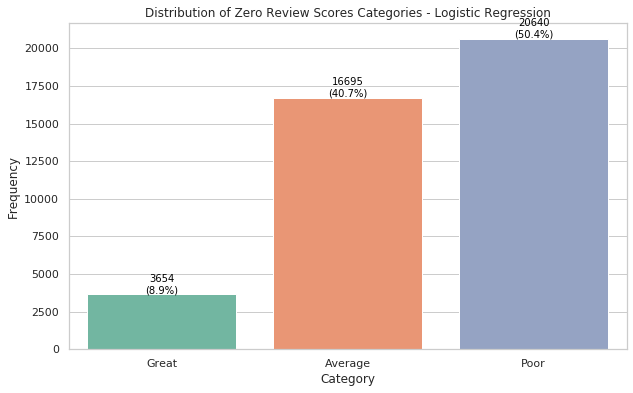

In [107]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")
# Setting up the figure for plotting
plt.figure(figsize=(10, 6))

# Creating a count plot for the 'target' column
ax = sns.countplot(x='prediction', data=zeroReviewPredictions.toPandas(), order=[2,1,0], palette='Set2')

# Calculating the total number of non-NaN entries for percentage calculation
total = len(zeroReviewPredictions.toPandas()['prediction'].dropna())

# Annotating each bar with the count and percentage
for p in ax.patches:
    count = p.get_height()  # The height of the bar is the count of values in this category
    percentage = f'{100 * count / total:.1f}%'  # Calculating the percentage of the total
    ax.annotate(f'{count}\n({percentage})', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=10, color='black', xytext=(0, 10),
                textcoords='offset points')

# Setting the title and labels
plt.title('Distribution of Zero Review Scores Categories - Logistic Regression')
plt.xlabel('Category')
plt.ylabel('Frequency')
plt.xticks(ticks=[0, 1, 2], labels=['Great', 'Average', 'Poor'])  # Optional: Rotate the x-axis labels for better readability

# Showing the plot
plt.show()

In [28]:
spark.stop()